In [83]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from epimodel.pymc3_models.epi_params import bootstrapped_negbinom_values, ci_to_mean_sd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

# infected to reporting

In [170]:
symptom_reporting = {
    'mean_mean': 5.82,
    'mean_sd': 0.68,
    'disp_mean': 1.57,
    'disp_sd': 0.054,
    'source': 'Cereda et al, https://arxiv.org/ftp/arxiv/papers/2003/2003.09320.pdf, §3'
              'Fonfria et al, https://www.medrxiv.org/content/medrxiv/early/2020/06/19/2020.06.17.20133587',
    'dist': 'negbinom',
    'notes': 'mean from Fronfria et al. Dispersions from Cereda et al.'
}

symptom_deaths = {
    'mean_mean': 16.71,
    'mean_sd': 0.75,
    'sd_mean': 6.9,
    'sd_sd': 1.122,
    'source': 'Linton et al'
              'Fonfria et al, https://www.medrxiv.org/content/medrxiv/early/2020/06/19/2020.06.17.20133587',
    'dist': 'gamma',
    'notes': 'Mean from Fronfria et al. Sd from Linton et al'
}

In [97]:
import scipy.stats as stats

In [98]:
w = stats.weibull_min(c=2.82)

In [100]:
5.665 * w.mean()

5.045779873608356

In [104]:
ci_to_mean_sd(2.826, np.array([1.75, 4.7]))

(2.826, 0.9561400182768016)

In [105]:
ci_to_mean_sd(5.665, np.array([4.7, 6.9]))

(5.665, 0.6301136193019478)

In [101]:
5.665 * w.std()

1.9384141921884563

In [138]:
nRVs = 2500

ms = np.zeros(nRVs)
sds = np.zeros(nRVs)

for i in tqdm(range(nRVs)):
    shape = np.random.uniform(1.75, 4.7)
    scale = np.random.uniform(4.7, 6.9)
#     shape=  max(np.random.normal(loc=2.926, scale=0.96), 1.5)
#     scale = max(np.random.normal(loc=5.665, scale=0.63), 3)
    w = stats.weibull_min(c=shape)
    ms[i] = scale * w.mean()
    sds[i] = scale * w.std()

print(np.mean(ms))
print(np.std(ms))   
print(np.mean(sds))
print(np.std(sds))

100%|██████████| 2500/2500 [00:02<00:00, 1194.55it/s]

5.203199686328215
0.5761618010494474
1.88764123760679
0.5016005756215961


In [149]:
ci_data = np.loadtxt('ci_data.csv', delimiter=',', skiprows=1, usecols=[1, 2, 4])

In [154]:
means = np.exp(ci_data[:, 0]) / np.exp(ci_data[:, 1])
sigmas = np.exp(0.5*ci_data[:, 0]) / np.exp(ci_data[:, 1])

nLogL = ci_data[:, 2]

In [161]:
nLogL < 3.84

array([False, False, False, ..., False, False, False])

In [163]:
np.min(sigmas[nLogL < 3.84])

1.5246482446412195

In [164]:
np.max(sigmas[nLogL < 3.84])

3.082620803862864

In [167]:
sd_middle = 2.11

In [169]:
ci_to_mean_sd(2.11, np.array([1.525, 3.09]))

(2.11, 0.5000091877861609)

In [165]:
np.min(means[nLogL < 3.84])

4.223214285714279

In [166]:
np.max(means[nLogL < 3.84])

5.964285714285696

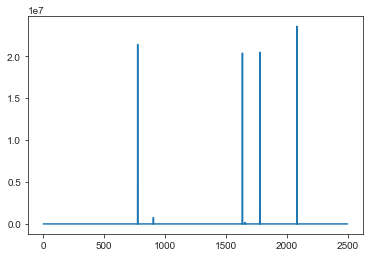

In [125]:
plt.plot(ms)

In [76]:
ms = np.linspace(1.5, 1.55, 51)
sds = np.linspace(0.05, 0.1, 51)

nRVs = int(1e7)

noise_mean = np.random.normal(0, 1, size=nRVs)
noise_sd = np.random.normal(0, 1, size=nRVs)

min_sd = 100
best_sol = np.array([0., 0.])
tol = 0.01

sd_mean = 0.418
sd_sd = 0.0759

for mean_mean in tqdm(ms.tolist()):
    for mean_sd in sds:
        log_mean = mean_mean + noise_mean * mean_sd
        log_sd = sd_mean + noise_sd * sd_sd
        means = np.exp(log_mean + 0.5 * log_sd ** 2)
        m = np.mean(means)
        l = np.percentile(means, 2.5)
        u = np.percentile(means, 97.5)
        if np.abs(m - 5.06) < tol:
            if l < 5.06 and u > 5.7:
                if mean_sd < min_sd:
                    min_sd = mean_sd
                    best_sol[0] = mean_mean
                    best_sol[1] = mean_sd
print(f'Best solution: {best_sol}')

100%|██████████| 51/51 [14:05<00:00, 16.58s/it]

Best solution: [1.53  0.051]


In [90]:
# final 
incubation_period = {
                'mean_mean': 1.53,
                'mean_sd': 0.051,
                'sd_mean': 0.418,
                'sd_sd': 0.0759,
                'source': 'Lauer et al, doi.org/10.7326/M20-0504'
                          'Fonfria et al, https://www.medrxiv.org/content/medrxiv/early/2020/06/19/2020.06.17.20133587',
                'dist': 'lognorm',
                'notes': 'mean_mean, mean_sd chosen from Fonfria et al, after fitting using Lauer values.'
                         '(log) sd, sd_sd taken from Lauer et al.'
            }

In [96]:
bootstrapped_negbinom_values([incubation_period, symptom_reporting])

100%|██████████| 250/250 [06:20<00:00,  1.52s/it]


({'mean_mean': 10.92830227448381,
  'mean_sd': 0.9387435298564465,
  'disp_mean': 5.406593726647138,
  'disp_sd': 0.2689502951493133,
  'dist': 'negbinom'},
 array([12.60279769, 12.30014823, 10.46197631, 12.63903016, 10.99029876,
        11.22249058, 10.69226513, 12.38574091, 11.14208528, 10.81418936,
        12.2529181 , 12.47288785, 11.20078998, 10.32221456, 12.34270589,
        10.61938993, 10.77206318, 10.87431967, 11.37356361, 11.01200283,
        11.72856641, 10.79026322, 10.57740604, 11.49299402, 11.99672747,
        11.25902239, 10.79261461, 12.02441551, 11.60161769, 10.59111587,
         9.95126361, 10.42228202, 10.70295163, 10.34967373, 10.97734477,
         9.05725156, 11.79436291, 10.92326091, 11.75977328, 12.22687728,
        10.27477721, 10.62472945, 11.30381544, 10.96773373, 10.38861634,
        10.92832054, 11.63875087, 10.29801906,  9.79438951,  9.77409951,
         9.41086777, 10.60815372, 11.1661132 , 11.2674392 ,  9.00814512,
         9.33964079,  9.98596125, 10.708

In [92]:
p, ms, disps = bootstrapped_negbinom_values([incubation_period, symptom_deaths], truncation=64)

100%|██████████| 250/250 [03:15<00:00,  1.28it/s]


In [93]:
p

{'mean_mean': 21.819649695284962,
 'mean_sd': 1.0056755718977664,
 'disp_mean': 14.26238141720708,
 'disp_sd': 5.177442947725441,
 'dist': 'negbinom'}